In [188]:
##### from __future__ import division

%matplotlib notebook
#%matplotlib inline
import time
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
from math import atan2, log, ceil
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
import copy
import datetime
from collections import Counter
from matplotlib import colors as mcolors

from importlib import reload
import roadmap
reload(roadmap)
from roadmap import Roadmap
import particle
reload(particle)
from particle import Particle
import pf
reload(pf)
from pf import PFJupyter as PF
import agent
reload(agent)
from agent import AgentJupyter as Agent
from agent import AgentJupyterRandom as AgentRandom
from agent import AgentJupyterPerfect as AgentPerfect
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

/home/mouse/projects/magicc/mass/algorithms/agent.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/mouse/.virtua

In [78]:
# Variance and Entropy calculations
def calc_entropy(r, X, res=1):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0.0
    hist = []
    nodes_visited = []
    counts = []
    probs = []
    for start in r.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in r[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
#                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    counts.append(count)
                    p = count / (N*M)
                    probs.append(p)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
    return h, get_pos_var(X, hist), counts, probs

def get_pos_var(X, bins):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

def get_vel_var(X):
    return np.var(X[:,:,2:3])

def getProb(variance, mean, pos):
    p = np.multiply((1/np.sqrt(2*np.pi*variance)), np.exp(-(pos-mean)/(2*variance)))
    return p

def getPredictedEntropy(variance, mean, max_distance, segment_size):
    entropy = 0
    for pos in range(0, max_distance, segment_size):
#         print(pos)
        p = getProb(variance, mean, pos)
        entropy -= p*np.log(p)
    return entropy

In [79]:
class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
    
    def update(self, z, R, lone_target, radius=None, p_fa=None):
        w = np.zeros(self._N)

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                if np.sum(l) < 10*np.finfo(float).eps:
                    continue
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
                
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

In [80]:
def sim(rbpf, r, targets, R, dt, T_end, plot=True, agent=None):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(targets[0].state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
        if agent is not None:
            agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = []
    counts = []
    probs = []
    particles = []
    for i in range(15):
        targets[0].predict()
        rbpf.predict()
        rbpf.update(mvn.rvs(targets[0].loc, R), R, lone_target=True, radius=1)
    
    # update the scenario
    for i in range(int(T_end/Ts)):
#     for i in tqdm(range(int(T_end/Ts))):
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            if agent is not None:
                dists.append(np.linalg.norm(target.loc - agent.pos))
        if agent is not None:
            if agent is not None:
                if i % int(1/Ts) == 0 and i != 0:
        #             if (dist1 < agent.fov) != (dist2 < agent.fov):
                    if dists[0] < agent.fov:
                        z = mvn.rvs(targets[0].loc, R)
                        rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
        #                 if dist2 < agent.fov:
        #                     z = mvn.rvs(target2.loc, R)
        #                     rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
        #             elif (dist1 < agent.fov) and (dist2 < agent.fov):
        #                     z = mvn.rvs(target1.loc, R)
        #                     rbpf.update(z, R, lone_target=False)
        #                     z = mvn.rvs(target2.loc, R)
        #                     rbpf.update(z, R, lone_target=False)
                    else:
                        rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            locs1 = rbpf.best[0].X[:,:2]
            sc1.set_offsets(locs1)
    #         locs2 = rbpf.best[1].X[:,:2]
    #         sc2.set_offsets(locs2)
            sc_target1.set_offsets(targets[0].loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
        if agent is not None:
            agent.update(None)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H_current, var_pos, part_dist, p = calc_entropy(r.graph, X)
        H += [H_current]
        variances.append(var_pos)
        counts += [part_dist]
        probs += [p]
        particles += [X]
#         variances[1].append(var_vel)

    return H, variances, counts, probs, particles

def runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa=.02, P_miss=.05, v0=4.5,
                  sigma=4, num_targets=1, e0=None, x0=None, one_edge=False, plot=False, agent_path=None,
                 get_entropy=True, get_variance=False, get_counts=False, get_prob=False, get_particles=False):
    r = Roadmap(nodes, edges, rotate=False)
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma,
               'P_fa':P_fa, 'P_miss':P_miss, 'one_edge': one_edge}
    R = 5*np.eye(2)
    H = []
    variances = []
    counts = []
    probs = []
    particles = []
    for idx in tnrange(num_runs):
        rbpf = RB_PF(r, 10, num_targets, pf_args)
        targets = []
        for jdx in range(num_targets):
            if x0 is not None:
                targets.append(Particle(r, v0=v0, dt=dt,e0=e0[jdx], x0=x0[jdx], sigma=sigma))
            else:
                targets.append(Particle(r, v0=v0, dt=dt, sigma=sigma))
        
#         agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)
        if agent_path is None:
            agent = None
        else:
            agent = AgentPerfect((100, 60), 100, 50, 40, 30, r, dt=dt, path=agent_path)
        H_tmp, variance, count, prob, part = sim(rbpf, r, targets, R, dt, T_end, plot=plot, agent=agent)
        if get_entropy:
            H += [H_tmp]
        if get_variance:
            variances += [variance]
        if get_counts:
            counts += [count]
        if get_prob:
            probs += [prob]
        if get_particles:
            particles += [part]
    return_data = []
    if get_entropy:
        h = np.nanmean(H, axis=0)
        return_data.append(h)
    if get_variance:
        v = np.nanmean(variances, axis=0)
        return_data.append(v)
    if get_counts:
        c = np.nanmean(counts, axis=0)
        return_data.append(c)
    if get_prob:
        p = np.nanmean(probs, axis=0)
        return_data.append(p)
    if get_particles:
        particles = np.array(particles)
        return_data.append(particles)
    return return_data

In [81]:
def getEntropy(probability, mode_probability):
    entropy = 0
    for num_modes in mode_probability.keys():
        for idx in range(len(probability)):
            if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:
                entropy += mode_probability[num_modes]*(-probability[idx]*np.log((1/num_modes)*probability[idx]))
    return entropy

def getProbAndEntropy(variance, x, mu, mode_probability,step_size):
    probability = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
    cdf = []
    for idx in range(0,len(probability),step_size):
#         cdf_sum = 0
#         for jdx in range(idx, step_size):
#             cdf_sum += sum(probability[:jdx])
        cdf.append(sum(probability[:idx]))
#         cdf.append(cdf_sum)
#     print(cdf)
#     print(sum(probability))
#     cdf = norm.cdf(x=x,loc=mu, scale=variance)
#     print(cdf)
#     print(np.concatenate(([0], cdf[0:-1])))
    probability = cdf - np.concatenate(([0], cdf[0:-1]))
#     print(probability)
    entropy = getEntropy(probability, mode_probability)
    return probability, entropy

def getProbAndEntropyOverTime(var_0, map_size, dt, sigma, num_steps, mode_probability, step_size=1):
    mu = map_size/2.
    distance = np.array([idx for idx in range(0,int(map_size), 1)])
    prob_over_time = []
    entropy_over_time = []
    for idx in range(num_steps):
        var = var_0 + idx*(dt*sigma)**2
#         print(mode_probability[idx])
        prob, entropy = getProbAndEntropy(var, distance, mu, mode_probability[idx], step_size)
        prob_over_time.append(prob)
        entropy_over_time.append(entropy)
    return prob_over_time, entropy_over_time


## Possible Useless Methods

In [82]:
def findMerge(base, initial_option, max_duration):
    options = base[initial_option]['options']
    durations = {}
    percent = 1.
    unvisited = [(base[initial_option]['offset'], option, percent*1./len(base[initial_option]['options']))
                 for option in base[initial_option]['options']]
    count = 0
    while len(unvisited) > 0:
        node = unvisited.pop(0)
        for option in base[node[1]]['options']:
            percent = node[2] * 1./len(base[node[1]]['options'])
            if node[0]+base[option]['offset'] < max_duration:
                unvisited.append((node[0] + base[node[1]]['offset'], option, percent))
        if node[0] not in durations:
            durations[node[0]] = {}
        if node[1] not in durations[node[0]]:
            durations[node[0]][node[1]] = 0
        durations[node[0]][node[1]] += node[2]
        if count > 50:
            break
        count += 1
    print(durations)
    
dist = 50
v0 = 10
base = {
    0: {'offset': dist/v0,
       'options': [1,1]},
    1: {'offset': dist*3/v0,
       'options': [0,1]},
#     2: {'offset': 15,
#        'options': [0,1]}
}
findMerge(base,0, 30)

{5.0: {1: 1.0}, 20.0: {0: 0.5, 1: 0.5}, 35.0: {0: 0.25}}


## Mode Splitting Algorithm Proof

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


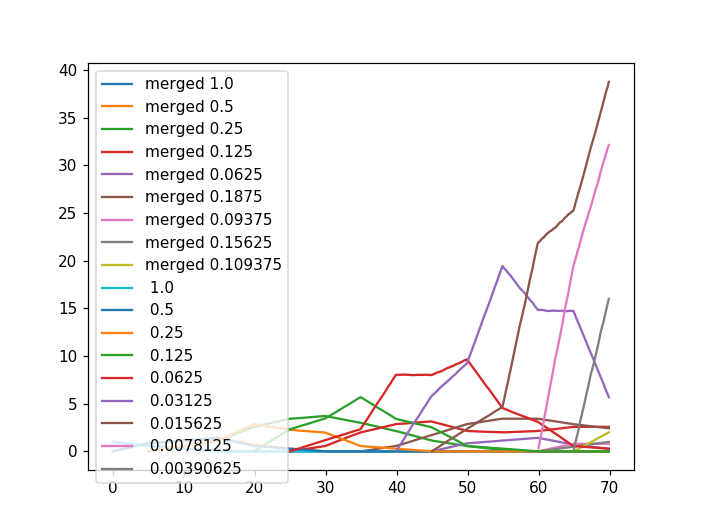

In [187]:

import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData
dt = .1
dist_e = 50
duration = 70
num_runs = 10000
layout = (2,3)
modes_over_time_2x3_merged = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs,merging_allowed=True)
# modes_over_time_2x3 = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
plt.figure()
plotModeData(modes_over_time_2x3_merged, dt, duration, label='merged')
modes_over_time_2x3 = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
plotModeData(modes_over_time_2x3, dt, duration)
# # print(modes_over_time_2x3)
# layout = (3,3)
# modes_over_time_3x3 = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
# plt.figure()
# plotModeData(modes_over_time_3x3, dt, duration)

<IPython.core.display.Javascript object>


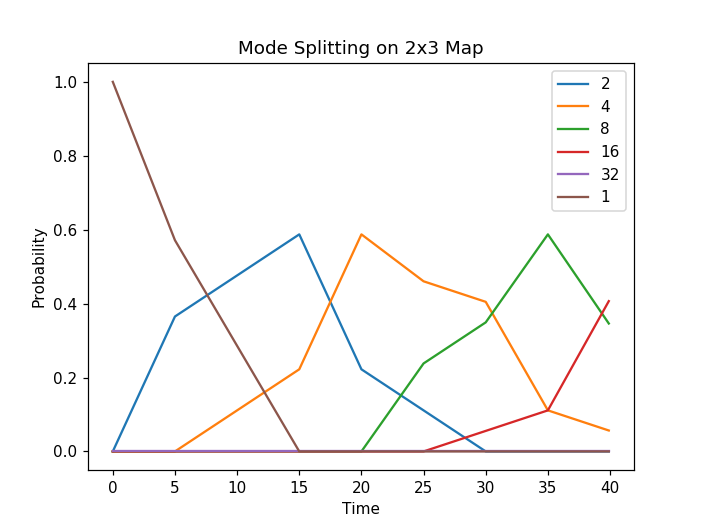

<IPython.core.display.Javascript object>


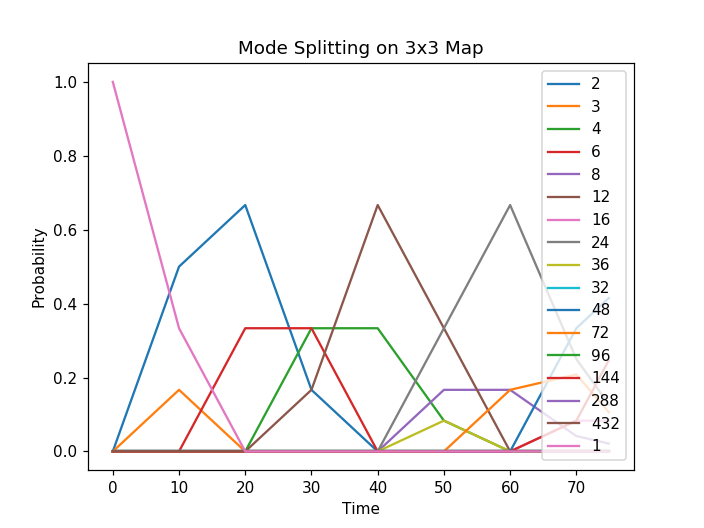

In [20]:
## Mode Splitting for 2x3 and 3x3
dist_e = 50
v0 = 10
map_dict2x3 = {
    'base': {
        'offsets': [0,0],
        'options': [0,1],
        'range': [3*dist_e/v0, dist_e/v0],
        'prob': [6./7, 1./7]
    },
    0: {'offsets': [3*dist_e/v0,dist_e/v0],
       'options': [0,1],
       'range': 3*dist_e/v0,
       'prob':4./6},#4/6
    1: {'offsets': [3*dist_e/v0,3*dist_e/v0],
       'options': [0,0],
       'range': dist_e/v0,
       'prob': 1./7}
}
t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, 40)

plt.figure()
plt.title("Mode Splitting on 2x3 Map")
for key in prob_data:
    plt.plot(t,prob_data[key], label=key)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()

map_dict3x3 = {
    'base': {
        'offsets': [0,0,0],
        'options': [0,1,2],
        'range': [20, 10, 10],
        'prob': [4./6, 1./6, 1./6]
    },
    0: {'offsets': [20,10],
       'options': [0,1],
       'range': 20,
       'prob':4./6},#4/6
    1: {'offsets': [10,10,10],
       'options': [2,2,2],
       'range': 10,
       'prob': 1./6},#1/6
    2: {'offsets': [20,20],
       'options': [0,0],
       'range': 10,
       'prob': 1./6}#1/6
}
t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, 75)

plt.figure()
plt.title("Mode Splitting on 3x3 Map")
for key in prob_data:
    plt.plot(t,prob_data[key], label=key)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()


# Single Mode Entropy

In [332]:
##
dist_e = 300
nodes = [(0.,0.), (dist_e,0.)]

edges = [(0, 1)]

N = 1000
dt = 0.1
T_end = 55
num_runs = 200

v0 = 4.5
sigma = 4

h, v, p = runIterations(nodes, edges, N, dt, T_end, num_runs, v0=v0,
                           sigma=sigma, e0=[(nodes[1], nodes[0])], x0=[.03], one_edge=True,
                           get_entropy=True, get_variance=True, get_prob=True)

In [333]:
variance_to_entropy_proof = {
    'h':h,
    'v':v,
    'p':p,
}
# print(variance_to_entropy_proof['v'])

In [334]:
##
h = variance_to_entropy_proof['h']
v = variance_to_entropy_proof['v']
p_data = variance_to_entropy_proof['p']

v = np.array(v)
predicted_v = [v[0] + idx*(dt*sigma)**2 for idx in range(v.shape[0])]
mu = 300
max_dist = 300
x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist),1)])
p_data = np.array(p_data)
ent = []
predicted_ent = []
p_by_time = []
p_est_by_time = []
predicted_est_by_time = []
bias = 0
map_size = 600
mode_probability = [{1:1} for idx in range(v.shape[0])]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], map_size, dt, sigma, v.shape[0], mode_probability)
for idx in range(v.shape[0]):
    #calculate entropy and probability based on variance
    var = v[idx]
    est, entropy = getProbAndEntropy(var, x, mu, mode_probability[idx], 1)
#     print(entropy)
    p_est_by_time.append(est)
    ent.append(entropy)
entropy_from_sim_prob = []
for idx in range(p_data.shape[0]):
    entropy_from_sim_prob.append(getEntropy(p_data[idx], {1:1}))
    
p_est_by_time = np.array(p_est_by_time)
#rk4
# 0 order whole

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


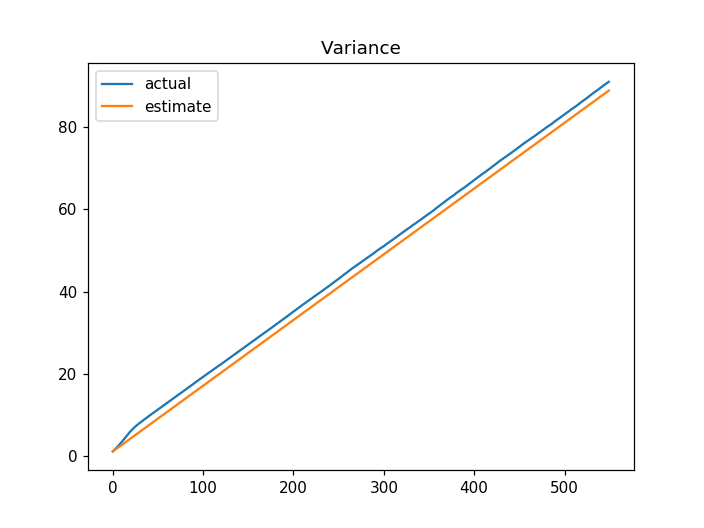

<IPython.core.display.Javascript object>


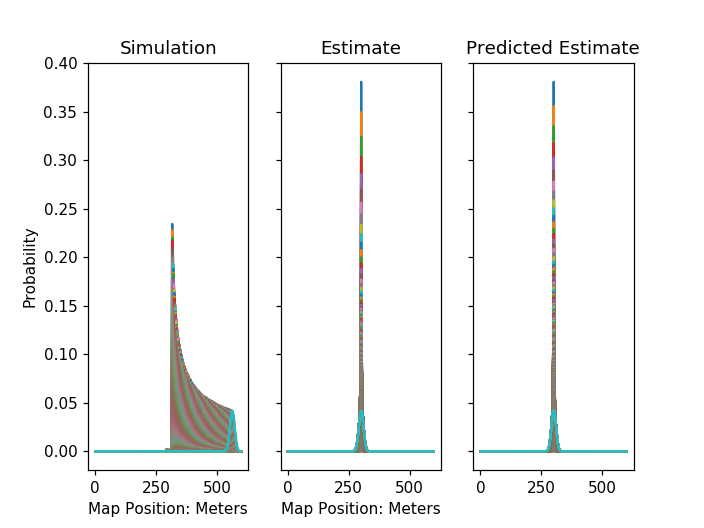

<IPython.core.display.Javascript object>


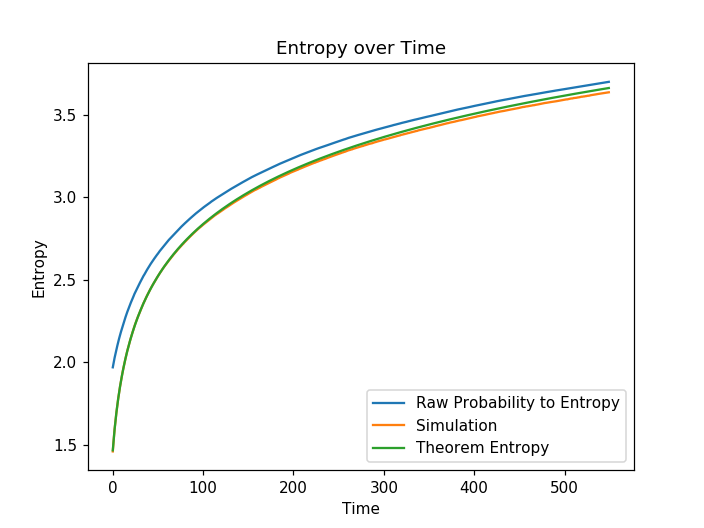

In [336]:
# print(predicted_v)
fig, ax = plt.subplots()
ax.set_title("Variance")
ax.plot(v, label='actual')
ax.plot(predicted_v, label='estimate')
ax.legend()
fig, ax = plt.subplots(1,3, sharey='row')
ax[0].set_ylabel("Probability")
ax[0].set_title('Simulation')
ax[1].set_title('Estimate')
ax[2].set_title('Predicted Estimate')
ax[0].set_xlabel('Map Position: Meters')
ax[1].set_xlabel('Map Position: Meters')
sim_x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist))])
for idx in range(v.shape[0]):
    ax[0].plot(np.array(p_data[idx]))
    ax[1].plot(p_est_by_time[idx])
    ax[2].plot(predicted_est_by_time[idx])

fig, ax = plt.subplots()
ax.set_title("Entropy over Time")
ax.set_ylabel("Entropy")
ax.set_xlabel("Time")
# ax.plot(ent,label='continus calculation')
ax.plot(entropy_from_sim_prob, label='Raw Probability to Entropy')
ax.plot(h, label='Simulation')
ax.plot(predicted_ent, label='Theorem Entropy')
ax.legend()


# Multiple Mode Entropy

## Single Scenario

In [348]:
##
dist_e = 50.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]
# initialize the roadmap
# r = Roadmap(nodes, edges, rotate=False)

N = 1000
dt = 0.1
T_end = 55
num_runs = 10

P_fa = 0.02
P_miss = 0.05
v0 = 10
sigma=4
h, v, c, p_data = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss,
                                v0=v0, sigma=sigma, num_targets=1, e0=[(nodes[0], nodes[1])], x0=[.5],
                               get_entropy=True, get_variance=True, get_counts=True, get_prob=True)

In [351]:
##
split_0 = 8
split_1 = 54
split_2 = 154
split_3 = 250
split_4 = 300
split_5 = 350
mode_probability = [{1: int(idx<split_0),
                     2:int(idx>=split_0 and idx < split_1),
                     3:int(idx>=split_1 and idx < split_2),
                     4:int(idx>=split_2 and idx < split_3),
                     5:int(idx>=split_3 and idx < split_4),
                     6:int(idx>=split_4 and idx < split_5),
                     7:int(idx>=split_5)
                    } for idx in range(v.shape[0])
                   ]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], 100, dt, sigma, v.shape[0], mode_probability)
# print(one_mode)

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


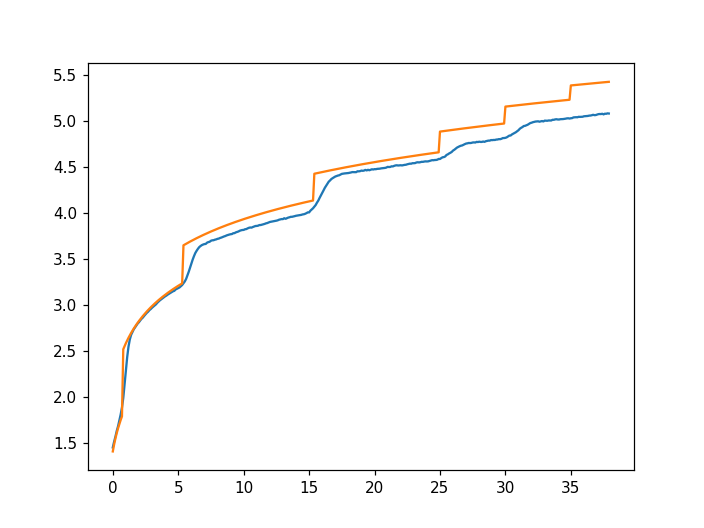

In [352]:
fig, ax = plt.subplots()
pre_overlap = 380
t = [dt*idx for idx in range(pre_overlap)]
ax.plot(t,h[:pre_overlap])
ax.plot(t,predicted_ent[:pre_overlap])

## All Scenarios Averaged

In [8]:

dist_e = 50.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]

v0 = 10
N = 1000
dt = 0.1
T_end = 55
num_runs = 100

P_fa = 0.02
P_miss = 0.05
sigma = 4
h, v, c, p_data = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss,
                                v0=v0, sigma=sigma, num_targets=1, get_entropy=True,
                                get_variance=True, get_counts=True, get_prob=True)

In [189]:
dist_e = 50
def new_way(duration, dt):
    map_dict2x3 = {
        'base': {
            'offsets': [0,0],
            'options': [0,1],
            'range': [3*dist_e/v0, dist_e/v0],
            'prob': [6./7, 1./7]
        },
        0: {'offsets': [3*dist_e/v0,dist_e/v0],
           'options': [0,1],
           'range': 3*dist_e/v0,
           'prob':4./6},#4/6
        1: {'offsets': [3*dist_e/v0,3*dist_e/v0],
           'options': [0,0],
           'range': dist_e/v0,
           'prob': 1./7}
    }
    t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, duration)
    return t, prob_data

def old_way(length, dt):
    def get_time_(t, ts, offset, initial_range):
        time = t - (ts + offset)
        time[np.where(time<0)] = 0
        time[np.where(time>initial_range)] = initial_range
        return time
    def get_prob_of_mode_type_(prob, initial_range, ts, options, base, t, level, desired_level):
        z = np.zeros((t.shape[0]))
        o = np.zeros((t.shape[0]))
        p = z
        num_options = len(options)
        next_prob = 1./num_options
        if level == desired_level:
            p = prob*get_time(t, ts, 0, initial_range)
            for idx in range(num_options):
                offset = base[options[idx]]['offset']
                p = p - prob*next_prob*get_time_(t, ts, offset, initial_range)
    #         p = 2**level * p
        else:
            first_death = t[-1]+1
            for idx in range(num_options):
                if level < desired_level:
                    offset = base[options[idx]]['offset']
                    next_options = base[options[idx]]['options']
                    p = p + prob*get_prob_of_mode_type_(next_prob, initial_range, ts+offset, next_options, base, t, level+1, desired_level)

        return p
    def getModeProbabilities_(prob, initial_range, base, t, max_level):
        probabilities = {}
        start_level = 1
        prob_sum = [1 for idx in t]
        for desired_level in range(start_level,max_level):
            probabilities[2**desired_level] = [0 for idx in t]
            for idx in range(len(prob)):
                probabilities[2**desired_level] += prob[idx]*(1./initial_range[idx])*get_prob_of_mode_type_(
                    1, initial_range[idx], 0, base[idx]['options'], base, t, start_level, desired_level)
            prob_sum -= probabilities[2**desired_level]
        probabilities[1] = prob_sum
        return probabilities
    base = {
        0: {'offset': 5,
           'options': [1,1]},
        1: {'offset': 15,
           'options': [0,1]}
    }
    t = np.array([i*dt for i in range(length)])
    prob_data = getModeProbabilities_([1./7, 6./7], [5, 15], base, t, 10)
    return t, prob_data

# t, prob_data = old_way(h.shape[0],dt)
# t, prob_data = new_way(55,dt)
prob_data = modes_over_time_2x3_merged
probabilites_by_time = []
for idx in range(h.shape[0]):
    probabilites_by_time.append({})
    for key in prob_data.keys():
        probabilites_by_time[-1][key] = prob_data[key][idx]*key
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], dist_e*7, dt, sigma,
                                                                 v.shape[0], probabilites_by_time)
# sums = []
# for line in probabilites_by_time:
#     sums.append(0)
#     for key in line.keys():
#         sums[-1] += line[key]
# print(sums)
# plt.figure()
# for key in prob_data.keys():
#     plt.plot(prob_data[key], label=key)
# # for key in new_prob.keys():
# #     plt.plot(new_t, new_prob[key])
# plt.legend()

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


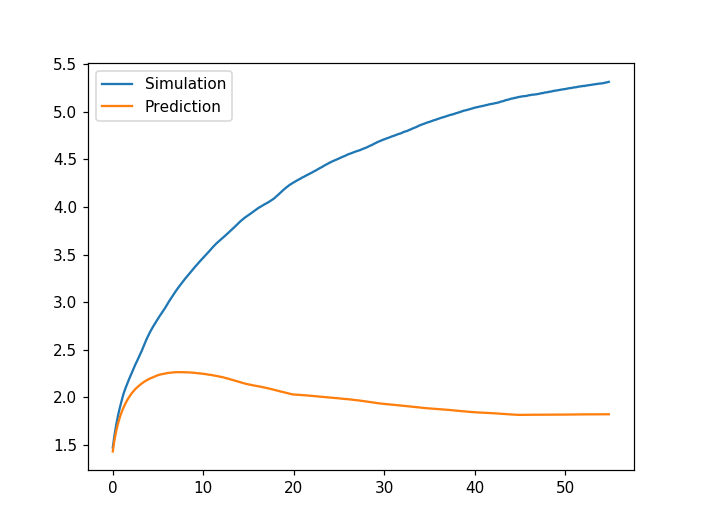

In [190]:
fig, ax = plt.subplots()
pre_overlap = h.shape[0]-1
t = [dt*idx for idx in range(pre_overlap)]
ax.plot(t,h[:pre_overlap], label='Simulation')
ax.plot(t,predicted_ent[:pre_overlap], label='Prediction')
ax.legend()

In [9]:

dist_e = 50.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]

base = {
    0: {'offset': 5,
       'options': [1,1]},
    1: {'offset': 15,
       'options': [0,1]}
}
N = 1000
dt = 0.1
T_end = 30
num_runs = 200

P_fa = 0.02
P_miss = 0.05
v0 = 10
sigma = 4
map_size = 350
h, v, c, p_data, particles = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss,
                                           v0=v0, sigma=sigma, num_targets=1, e0=[(nodes[0], nodes[1])],
                                           x0=[.2], plot=False)

In [10]:
split_0 = 20
map_size = 350
probabilites_by_time = [{1: int(idx<split_0),
                     2:int(idx>=split_0)
                    } for idx in range(h.shape[0])
                   ]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], map_size, dt, sigma,
                                                                 h.shape[0], probabilites_by_time)
print(len(predicted_ent))

300


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


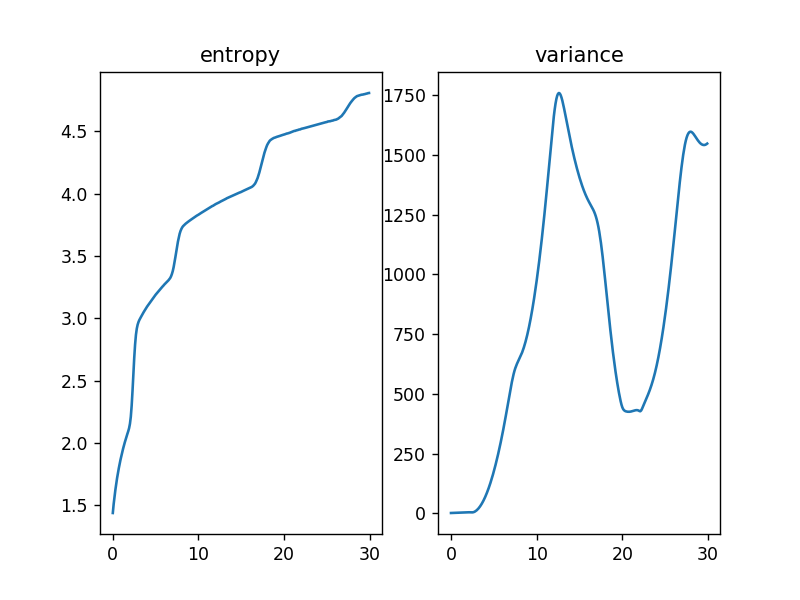

In [11]:
fig, ax = plt.subplots(1,2)
t = [dt*idx for idx in range(h.shape[0])]
ax[0].plot(t,h)
# ax[0].plot(t,predicted_ent)
ax[0].set_title('entropy')
ax[1].set_title('variance')
ax[1].plot(t,v)

In [7]:
def variance_on_edge(start, end, locs):
    min_x = min(start[0], end[0])
    max_x = max(start[0], end[0])
    min_y = min(start[1], end[1])
    max_y = max(start[1], end[1])
    in_x = locs[locs[:,0] >= min_x]
    in_x = in_x[in_x[:,0] <= max_x]
    in_y = in_x[in_x[:,1] >= min_y]
    in_y = in_y[in_y[:,1] <= max_y]
    if start[0] == end[0]:
        return np.var(in_y[:,1])
    else:
        return np.var(in_y[:,0])

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


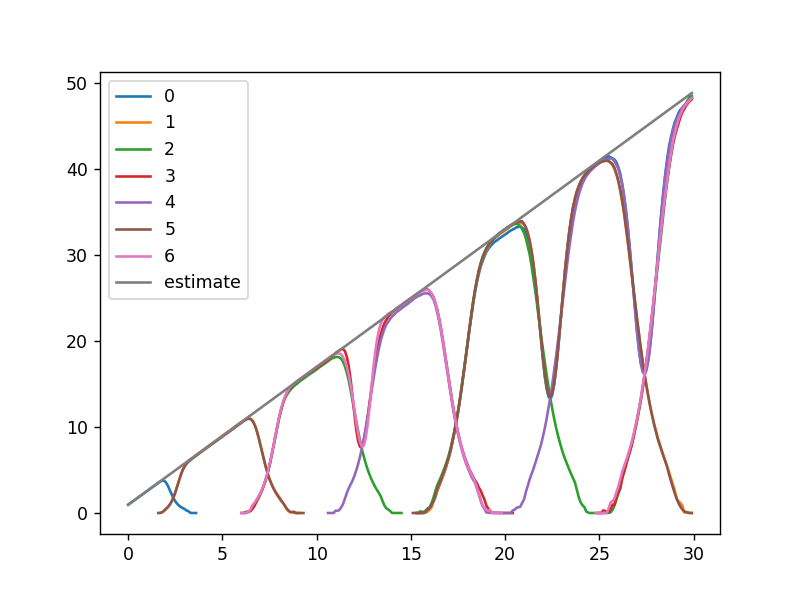

[9.62174217e-01 1.12264514e+00 1.28167683e+00 1.43668637e+00
 1.59272075e+00 1.75186279e+00 1.90947871e+00 2.07190190e+00
 2.23374861e+00 2.38871710e+00 2.54534310e+00 2.70523554e+00
 2.86687470e+00 3.02556853e+00 3.18709175e+00 3.34422965e+00
 3.49951745e+00 3.65013508e+00 3.75646416e+00 3.75140570e+00
 3.56446092e+00 3.18711275e+00 2.68601901e+00 2.16632096e+00
 1.71329964e+00 1.35246630e+00 1.06980942e+00 8.59154920e-01
 6.84769413e-01 5.69840261e-01 4.57512275e-01 2.82017248e-01
 1.98636041e-01 1.74177947e-02 1.23479449e-04 0.00000000e+00
 0.00000000e+00            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan         

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [20]:
# variance = {'a':[],'b':[],'c':[], 'd':[], 'e':[], 'f':[]}
variance = {idx:[] for idx in range(7)}
edges = [((0,0),(50,0)), ((50,0),(100,0)), ((0,50),(50,50)), ((50,50),(100,50)),
         ((0,0),(0,50)), ((50,0),(50,50)), ((100,0),(100,50))]
for idx in range(particles.shape[0]):
    part = particles[idx]
#     print(part.shape)
    for key in variance.keys():
        variance[key].append([])
    for jdx in range(part.shape[0]):
        loc = part[jdx,0,:,:2]
#         a = variance_on_edge((0,0), (50,0), loc)#loc[np.any(loc[:,0]<50 and loc[:,1]==0)][:,0]
#         b = variance_on_edge((50,0), (100,0), loc)#loc[loc[:,0]>50][:,0]
#         c = variance_on_edge((50,0), (50,50),loc)#loc[loc[:,1]>0][:,1]
#         d = variance_on_edge((0,50), (50,50), loc)
#         e = variance_on_edge((100,50),(50,50), loc)
#         f = variance_on_edge((100,0),(100,50), loc)
#         splits = {'a': a, 'b': b, 'c':c, 'd':d, 'e':e, 'f':f}
        splits = {
            idx: variance_on_edge(edges[idx][0], edges[idx][1], loc) for idx in range(7)
        }
        for key in variance.keys():
#             var = np.var(splits[key])
#             variance[key][-1].append(0 if np.isnan(var) else var)
            variance[key][-1].append(splits[key])
t = np.array([idx*dt for idx in range(v.shape[0])])
# fig, ax = plt.subplots()
for key in variance.keys():
    variance[key] = np.nanmean(variance[key],axis=0)
#     ax.plot(t, variance[key], label=key)
# ax.plot(t,v[0] + t*dt*(sigma)**2, label='estimate')
# ax.legend()
# print(variance[0])

In [22]:
def get_entropy_from_variance_direct(map_size, max_idx, start_idx, end_idx, modes, variance, min_variance):
    map_size = 350
    x = np.array([idx for idx in range(map_size)])
    mu = map_size/2.
    
    entropy = [0 for idx in range(max_idx)]
    
    for idx in range(start_idx, end_idx):
        for key in variance.keys():
            num_modes=9999999
            for modes_key in modes.keys():
                if idx < modes_key:
                    num_modes = min(num_modes, modes[modes_key][key])
#             print(variance[key][idx])
            if variance[key][idx] > min_variance:
                var = variance[key][idx]
#                 if idx > 220:
                print('key',key, num_modes, var)
                probability = 1./np.sqrt(2*np.pi*var)*np.exp(-(x-mu)**2/(2*var))
                entropy_vals = -(1./num_modes)*probability[probability>0]*np.log((1./num_modes)*probability[probability>0])
                entropy[idx] += np.nansum(entropy_vals[np.isfinite(entropy_vals)])
    return np.array(entropy)

map_size = 350
max_idx = h.shape[0]
indices = [(0,16),(35,65), (83,113), (120, 165), (186, 220), (230, 264)]
min_variances = [0, 4, 13, 18, 28, 30]
modes = {
    17: {idx:1 for idx in range(7)},
    70: {idx:2 for idx in range(7)},
    110: {idx: 2 if idx == 4 else 4 for idx in range(7)},
    165: {idx: 2 if idx == 3 else 4 for idx in range(7)},
    264: {idx: 4 for idx in range(7)}
}
entropy = [0 for idx in range(max_idx)]
predicted_ent = [0 for idx in range(max_idx)]
predicted_variance = {idx:v[0] + t*dt*(sigma)**2 for idx in range(7)}
for key in variance:
    for idx in range(len(variance[key])):
        segment = 0
        while segment < len(indices)-1 and idx > indices[segment][1]:
            segment += 1
        
        if np.isnan(variance[key][idx]) or variance[key][idx] < min_variances[segment]:
            predicted_variance[key][idx] = np.nan
# print(predicted_variance)
for segment in range(len(indices)):
    start_idx = indices[segment][0]
    end_idx = indices[segment][1]
    min_variance = min_variances[segment]
    entropy += get_entropy_from_variance_direct(map_size, max_idx, start_idx, end_idx, modes, variance, min_variance)
    predicted_ent += get_entropy_from_variance_direct(map_size, max_idx, start_idx, end_idx, modes, predicted_variance, min_variance)

NameError: name 't' is not defined

In [34]:
variance_entropy_plot = {
    'v': variance,
    'h': h
}

[nan nan nan nan nan]
[nan nan nan nan nan]


<IPython.core.display.Javascript object>


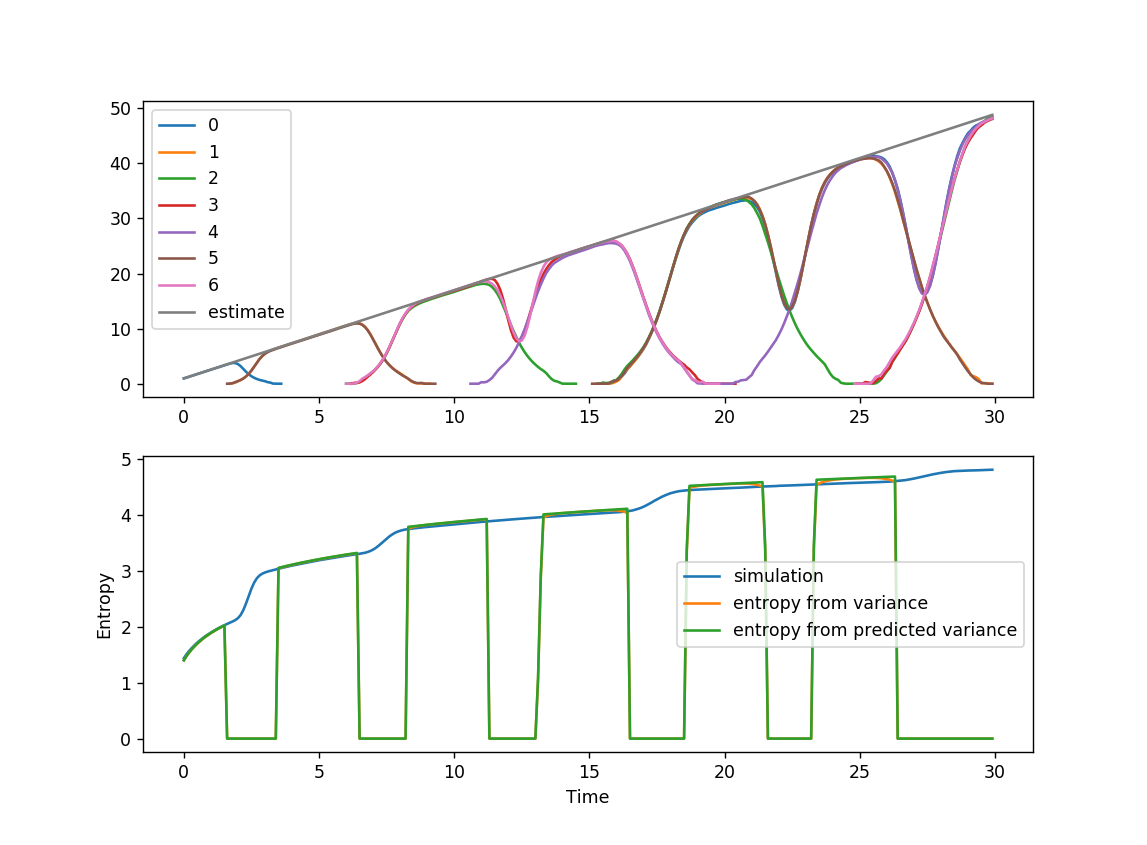

Text(0.5,0,'Time')

In [36]:
fig, ax = plt.subplots(2,1)
t = np.array([idx*dt for idx in range(v.shape[0])])
for key in variance.keys():
    ax[0].plot(t, variance[key], label=key)
pred_v_tmp = v[0] + t*dt*(sigma)**2
ax[0].plot(t,pred_v_tmp, label='estimate')
ax[0].legend()

ax[1].plot(t,h,label='simulation')
ax[1].plot([dt*idx for idx in range(len(entropy))],entropy, label='entropy from variance')
ax[1].plot([dt*idx for idx in range(len(entropy))],predicted_ent, label='entropy from predicted variance')
ax[1].legend()
ax[1].set_ylabel('Entropy')
ax[1].set_xlabel('Time')

## Everything put together

In [8]:
def DjikstraGraph(graph, initial_node):
    nodes = sorted(graph.keys())
    unvisited = sorted(graph.keys())
    visited = []
    dists = []
    paths = []
    for node in nodes:
        dists.append(np.inf)
        paths.append([])
        if node == initial_node:
            dists[-1] = 0
    while len(visited) < len(nodes):
        best_node = None
        best_node_val = -1
        for node in unvisited:
            if dists[nodes.index(node)] < best_node_val or best_node is None:
                best_node_val = dists[nodes.index(node)]
                best_node = node
        start_node = best_node
        visited.append(start_node)
        unvisited.remove(start_node)
        index_start = nodes.index(start_node)
        for node in graph[start_node].keys():
            index = nodes.index(node)
            new_dist = dists[index_start] + graph[start_node][node]
            if new_dist < dists[index]:
                dists[index] = new_dist
                paths[index] = paths[index_start]
                paths[index].append(node)
    return dists

def getAvgDistance(r):
    vals = []
    for node in sorted(r.graph.keys()):
        avg_dist = np.mean(DjikstraGraph(r.graph, node))
        vals.append(avg_dist)
    return np.mean(vals)

def createGridLayout(x,y,min_edge_length, max_edge_length):
    nodes = []
    edges = []
    for i in range(y):
        for j in range(x):
            x_val = 0
            y_val = 0
            if i > 0:
                y_val = nodes[(i-1)*x + j][1]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            if j > 0:
                x_val = nodes[i*x+j-1][0]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            nodes.append((
                x_val,
                y_val ))

    for i in range(y):
        for j in range(x-1):
            edges.append((j+x*i,j+1+x*i))
    
    for i in range(y-1):
        for j in range(x):
            edges.append((j+x*i,j+x*(i+1)))
    return [nodes, edges]

In [9]:
def get_pos_var(X, bins):
    return max(np.var(X[:,0:1]), np.var(X[:,1:2]))

def calc_entropy(graph, X, res=1):
    """Returns the entropy of the estimate in nats

        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """

    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
#         print(M)
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:,:, :2] - X[:,:, 3:5], axis=-1)
#         dists_reverse = np.linalg.norm(X[:,:, :2] - X[:, 5:6], axis=-1)

    h = np.zeros(M)
    hist = []
    nodes_visited = []
    counts = []
    probs = []
    for start in graph.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in graph[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = graph[start][end]
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:,:, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                for idx in range(M):
                    bin_start = 0.0
                    while bin_start < length:
#                             if idx != 0:
#                                 print('idx', idx)
                        in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
    #                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                        count = np.sum(np.all([on_edge[idx], in_bin[idx]], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                        counts.append(count)
#                             if idx > 0:
#                             if idx != 0:
#                                 print('idx', idx, 'count',count)
                        p = count / (N)
                        probs.append(p)
                        hist.append(p)
                        if p > 0:
                            h[idx] -= p*np.log(p)
                        bin_start += res
#     print(np.linalg.norm(h),)
    return h, [get_pos_var(X[idx], hist) for idx in range(M)], counts, probs

In [10]:
def sim(pfs, r, targets, R, dt, T_end, plot=True, agent=None, all_data=False):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)
        sc = []
        sc_targets = []
        colors = ['blue', 'green', 'yellow']
        for idx in range(len(targets)):
            x0 = pfs[idx].X[:,0]
            y0 = pfs[idx].X[:,1]
            sc.append(ax.scatter(x0, y0, s=10, linewidth=0, facecolor=colors[idx], label='particles'))
            loc = r.get_loc(targets[idx].state)
            sc_targets.append(ax.scatter(
                [loc[0]], [loc[1]], s=100, marker='*', facecolor=colors[idx], label='target'))

        if agent is not None:
            agent.init_plot(ax)
        ax.legend()

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        fig.canvas.draw()
        start = time.time()
        tic = start
    Ts = dt
    avg_distance = [[] for pf in pfs]
    num_in_threshold = [[] for pf in pfs]
    H = []
    variances = []
    if all_data:
        counts = []
        probs = []
        particles = []
    
    updated = [False for target in targets]
    # update the scenario
    for i in range(int(T_end/Ts)):
#     for i in tqdm(range(int(T_end/Ts))):
        for pf in pfs:
            pf.predict()
        dists = []
        for target in targets:
            target.predict()
            dists.append(np.linalg.norm(target.loc - agent.pos))
        if agent is not None:
            
#             if i % int(1/Ts) == 0 and i != 0:
#                 if (dists[0] < agent.fov) != (dists[1] < agent.fov):
                    for jdx in range(len(targets)):
                        if dists[jdx] < agent.fov:
                            if not updated[jdx]:
                                z = targets[jdx].loc#mvn.rvs(targets[jdx].loc, R)
                                pfs[jdx].update(z, R)
                                updated[jdx] = True
                        else:
                            updated[jdx] = False
#                             print('update', jdx)
#                     if dists[0] < agent.fov:
#                         z = mvn.rvs(targets[0].loc, R)
#                         pfs[0].update(z, R)#, lone_target=True, radius=agent.fov*0.75)
# #                     else:
# #                         pfs[0].neg_update(agent.pos, radius=agent.fov*.75)
#                     if dists[1] < agent.fov:
#                         z = mvn.rvs(targets[1].loc, R)
#                         pfs[1].update(z, R)#, lone_target=True, radius=agent.fov*0.75)
#                     else:
#                         pfs[1].neg_update(agent.pos, radius=agent.fov*.75)
#                 elif (dists[0] < agent.fov) and (dists[1] < agent.fov):
#                         z = mvn.rvs(targets[0].loc, R)
#                         pfs[0].update(z, R)#, lone_target=False)
#                         z = mvn.rvs(targets[1].loc, R)
#                         pfs[1].update(z, R)#, lone_target=False)
#                 else:
#                     for pf in pfs:
#                         pf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            for idx in range(len(sc)):
                locs = pfs[idx].X[:,:2]
                sc[idx].set_offsets(locs)
                sc_targets[idx].set_offsets(targets[idx].loc)
#             pfs = rbpf.best
#         pfs = rbpf.best
        if agent is not None:
            agent.update(pfs, targets)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([pf.X for pf in pfs])
        H_current, var_pos, part_dist, p = calc_entropy(r.graph, X, res=10)
        H += [H_current]
        variances.append(var_pos)
        if all_data:
            counts += [part_dist]
            probs += [p]
            particles += [X]
    if all_data:
        return H, variances, counts, probs, particles
    else:
        return H, variances

def runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa=.02, P_miss=.05, fov=30, v0=4.5, Va=40, sigma=4, num_targets=1,
                  e0=None, x0=None, one_edge=False, plot=False, agent_active=False, all_data=False):
    r = Roadmap(nodes, edges, rotate=False)
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma,
               'P_fa':P_fa, 'P_miss':P_miss, 'one_edge': one_edge}
    R = 5*np.eye(2)
    H = []
    variances = []
    if all_data:
        counts = []
        probs = []
        particles = []
    for idx in tnrange(num_runs):
        pfs = [PF(r, N, dt, v0=v0, sigma=sigma, P_fa=P_fa, P_miss=P_miss)
               for idx in range(num_targets)]
        targets = []
        for jdx in range(num_targets):
            if x0 is not None:
                targets.append(Particle(r, v0=v0, dt=dt,e0=e0[jdx], x0=x0[jdx], sigma=sigma))
            else:
                targets.append(Particle(r, v0=v0, dt=dt, sigma=sigma))
        if agent_active:
            agent = AgentPerfect(Va, r, dt=dt, fov=fov)
        else:
            agent = None
        if all_data:
            H_tmp, variance, count, prob, part = sim(pfs, r, targets, R, dt, T_end, plot=plot, agent=agent,
                                                     all_data=all_data)
        else:
            H_tmp, variance = sim(pfs, r, targets, R, dt, T_end, plot=plot, agent=agent, all_data=all_data)
        H += [H_tmp]
        variances += [variance]
        if all_data:
            counts += [count]
            probs += [prob]
            particles += [part]
    h = np.nanmean(H, axis=0)
    v = np.nanmean(variances, axis=0)
    if all_data:
        c = np.nanmean(counts, axis=0)
        p = np.nanmean(probs, axis=0)
        particles = np.array(particles)
        return h, v, c, p, particles
    else:
        return H, variances

<IPython.core.display.Javascript object>


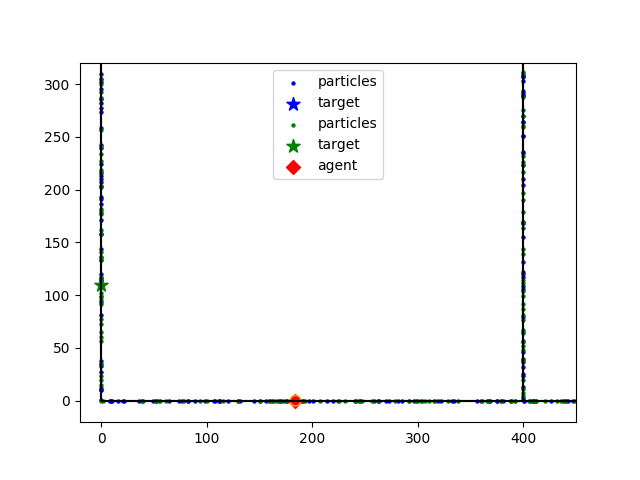

KeyboardInterrupt: 

In [88]:
reload(agent)
from agent import AgentJupyterPerfect as AgentPerfect
dist_e = 400.
nodes = [(0.,0.), (dist_e,0.), ( 2*dist_e, 0),
         (0.,dist_e), (dist_e, dist_e), (2*dist_e, dist_e)]#,
#          (0.,2*dist_e), (dist_e, 2*dist_e), (2*dist_e, 2*dist_e)]

edges = [(0, 1), (1,2), (0,3), (1,4), (2,5), (3,4), (4,5)]#, (3,6), (4,7), (5,8), (6,7), (7,8)]

P_fa = 0.0
P_miss = 0.0
v0 = 10
sigma = 4
map_size = dist_e*7

base = {
    0: {'offset': dist_e/v0,
       'options': [1,1]},
    1: {'offset': dist_e*3/v0,
       'options': [0,1]}
}
N = 400
dt = 0.1
T_end = 60
num_runs = 10
fov = 5

h, v = runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa, P_miss, fov=fov,
                  v0=v0, sigma=sigma, num_targets=2, plot=True, agent_active=True)

<IPython.core.display.Javascript object>


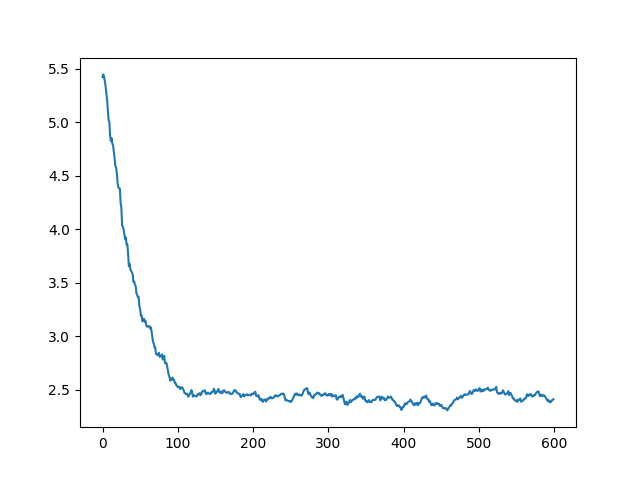

2.4338461085222285


In [523]:
# print(h)
h50 = np.array(h)
# h_test = np.concatenate((h,h_test), axis=0)
# h25 = h_test
# h_25 = np.array(h)
plt.figure()
# plt.plot(h[0,:,0])
data = np.mean(np.mean(h50, axis=0), axis=1)#[:,0]
plt.plot(data)
print(np.mean(data[100:]))
# plt.plot(np.mean(h_25, axis=0))
# plt.plot(v[0,:,0])
# plt.plot([2.6120496709820196 for idx in range(600)])

In [500]:
#np.mean(h, axis=0)#[300:,0]
v = np.array(v)
mins = []
for jdx in range(v.shape[0]):
    test = h[jdx,:,0]
# test = h[0,:,0]
    for idx in range(test.shape[0]-1):
        if test[idx] > test[idx+1]+1:
            mins.append(v[jdx,idx+1,0])
# print(mins)
# print(np.array(v).shape)
print(np.mean(mins))
print(np.min(mins))

TypeError: list indices must be integers or slices, not tuple

In [480]:
print(nodes)
print(edges)
Va = 40
nodes, edges = createGridLayout(2,3,dist_e, dist_e)
r = Roadmap(nodes, edges, rotate=False)
avg_dist = getAvgDistance(r)
dur = 2*avg_dist/Va
print(avg_dist, dur, dur/dt)

[(0.0, 0.0), (100.0, 0.0), (200.0, 0), (0.0, 100.0), (100.0, 100.0), (200.0, 100.0)]
[(0, 1), (1, 2), (0, 3), (1, 4), (2, 5), (3, 4), (4, 5)]
138.88888888888889 6.944444444444445 69.44444444444444


In [32]:
# t = np.array([dt*idx for idx in range(h.shape[0])])
# probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 15)
# probabilites_by_time = []
# for idx in range(h.shape[0]):
#     probabilites_by_time.append({})
#     for key in probabilities.keys():
#         probabilites_by_time[-1][key] = probabilities[key][idx]
# predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(2.9, int(map_size), dt, sigma,
#                                                                  my_h.shape[0], probabilites_by_time)
t = np.array([dt*idx for idx in range(100)])
probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 15)
probabilites_by_time = []
for idx in range(100):
    probabilites_by_time.append({})
    for key in probabilities.keys():
        probabilites_by_time[-1][key] = probabilities[key][idx]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.017, int(map_size), dt, sigma,
                                                                 100, probabilites_by_time)


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


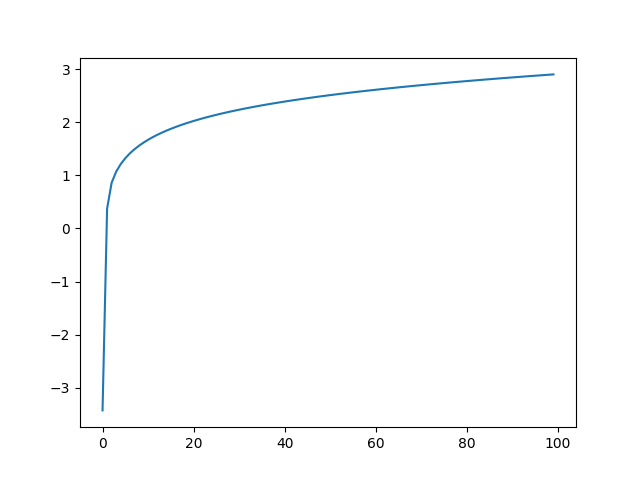

1.7209544567187136


In [33]:
# def fill_prediction(ent):
#     for idx in range(1,len(ent)):
#         if np.isnan(ent[idx]):
#             for jdx in range(idx,len(ent)):
#                 if not np.isnan(ent[jdx]):
#                     slope = (ent[jdx]- ent[idx-1])/(jdx-(idx-1))
#                     for kdx in range(idx, jdx):
#                         ent[kdx] = ent[idx-1] + slope*(kdx-(idx-1))
#                     break

#     return ent
# test = fill_prediction(np.copy(predicted_ent))
# print(test)

plt.figure()
# plt.plot(test)
plt.plot(predicted_ent)
print(np.mean(test[:int(dur/dt)]))

In [11]:
def fill_prediction(ent):
    for idx in range(1,len(ent)):
        if np.isnan(ent[idx]):
            for jdx in range(idx,len(ent)):
                if not np.isnan(ent[jdx]):
                    slope = (ent[jdx]- ent[idx-1])/(jdx-(idx-1))
                    for kdx in range(idx, jdx):
                        ent[kdx] = ent[idx-1] + slope*(kdx-(idx-1))
                    break

    return ent

In [46]:
#
# h_50 = np.load("data_50.0_h.npy")
# h_100 = np.load("data_100.0_h.npy")
# h_200 = np.load("data_200.0_h.npy")
# h_300 = np.load("data_300.0_h.npy")
# h_50 = np.load("data_no_neg_50.0_h.npy")
# h_100 = np.load("data_no_neg_100.0_h.npy")
# h_200 = np.load("data_no_neg_200.0_h.npy")
# h_300 = np.load("data_no_neg_300.0_h.npy")
raw_data = [
    
]
num_runs = 4
# h50_test = np.nanmean(np.nanmean(h_50, axis=2)[:num_runs], axis=0)
# h100_test = np.nanmean(np.nanmean(h_100, axis=2)[:num_runs], axis=0)
# h100nn_test = np.nanmean(np.nanmean(h_100nn, axis=2)[:num_runs], axis=0)
# h200nn_test = np.nanmean(np.nanmean(h_200nn, axis=2)[:num_runs], axis=0)
# h200_test = np.nanmean(np.nanmean(h_200, axis=2)[:num_runs], axis=0)
# h300_test = np.nanmean(np.nanmean(h_300, axis=2)[:num_runs], axis=0)
# h50_test = np.nanmean(h_50, axis=2)[0]
# h100_test = np.nanmean(h_100, axis=2)[0]
# h100nn_test = np.nanmean(h_100nn, axis=2)[0]
# h200nn_test = np.nanmean(h_200nn, axis=2)[0]
# h200_test = np.nanmean(h_200, axis=2)[0]
# h300_test = np.nanmean(h_300, axis=2)[0]
# plt.figure()
# data = [h50_test, h100_test, h200_test, h300_test]

# initial_variances = [4.04, 4.03, 3,93, 3,84, 3.61]
# dists = [50, 100, 200, 300]
dists = [150, 200, 250, 300, 350]
colors = ['red', 'blue', 'green', 'orange']
for idx in range(len(data)):
#     plt.plot(data[idx], color=colors[idx], label='Sim {}'.format(dists[idx]))
#     lower_bound = np.mean(data[idx][500:])
#     print(lower_bound)
#     plt.plot(
#         [lower_bound for jdx in range(len(data[idx]))], 
#         '--', color=colors[idx],
#         label='lower bound {}'.format(dists[idx]))
    dist_e = dists[idx]
#     Va = 40
#     nodes, edges = createGridLayout(2,3,dist_e, dist_e)
#     r = Roadmap(nodes, edges, rotate=False)
#     avg_dist = getAvgDistance(r)
#     dur = 2*avg_dist/Va
#     # print(avg_dist, dur, dur/dt)
    map_size = dists[idx]*7

    base = {
        0: {'offset': dist_e/v0,
           'options': [1,1]},
        1: {'offset': dist_e*3/v0,
           'options': [0,1]}
    }
    t = np.array([dt*idx for idx in range(100)])
    probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 15)
    probabilites_by_time = []
    for jdx in range(100):#h.shape[0]):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
# #     print(probabilites_by_time[0])
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(initial_avg_variances[idx], int(map_size), dt, sigma,
                                                                     len(probabilites_by_time), probabilites_by_time)

    test = fill_prediction(np.copy(predicted_ent))

    print('Variance: {} Entropy Bound: {}'.format(initial_avg_variances[idx], np.mean(test[:int(dur/dt)])))
# #     print(idx)
#     plt.plot([np.mean(test[:int(dur/dt)]) for jdx in range(100)],
#              color=colors[idx], label='Predicted {}'.format(dists[idx]))
# plt.plot(h100nn_test)
# plt.plot(h200nn_test)
plt.legend()

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Variance: 4.048881995102513 Entropy Bound: 2.7144538396769455
Variance: 4.032856360238168 Entropy Bound: 2.689136217391082
Variance: 3.934236693502447 Entropy Bound: 2.6694113279473948
Variance: 3.844597626363524 Entropy Bound: 2.654990062151017


KeyboardInterrupt: 

In [12]:
dists = [50, 100, 200, 300, 400]
probability_array = []
v0 = 10
Va = 40
for idx in range(len(dists)):
    print(dists[idx])
    base = {
        0: {'offset': dists[idx]/v0,
           'options': [1,1]},
        1: {'offset': dists[idx]*3/v0,
           'options': [0,1]}
    }
    nodes, edges = createGridLayout(2,3,dists[idx], dists[idx])
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
    print('duration: ', ceil(dur)/dt)
    
    t = np.array([dt*idx for idx in range(int(ceil(dur)/dt))])
    print('calculate mode probabilities')
    probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 10)
    probabilites_by_time = []
    for jdx in range(len(probabilities[1])):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
    probability_array.append(probabilites_by_time)
    print('finished calculation')
# print(probability_array[0])

50


NameError: name 'dt' is not defined

<IPython.core.display.Javascript object>


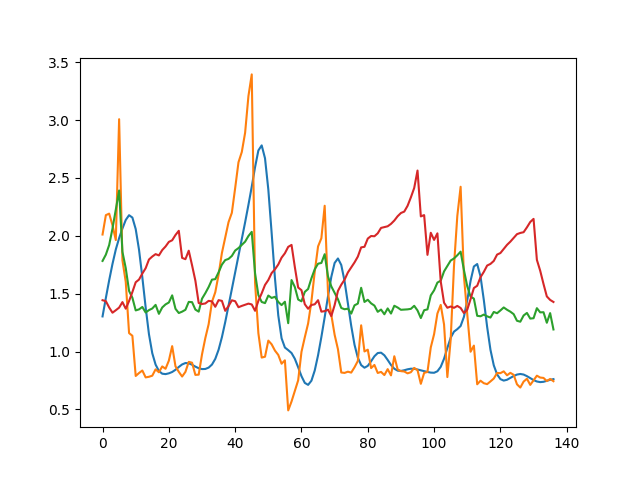

In [323]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

#     if x.ndim != 1:
#         raise ValueError, "smooth only accepts 1 dimension arrays."

#     if x.size < window_len:
#         raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


#     if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
#         raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

h_50 = np.load("data_50.0_h.npy")
v_50 = np.load("data_50.0_v.npy")
v_50_sm = smooth(v_50[3][:,0])
plt.figure()
plt.plot(v_50_sm[113:250])
plt.plot(v_50[3][113:250,0])
plt.plot(h_50[3][113:250])

<IPython.core.display.Javascript object>


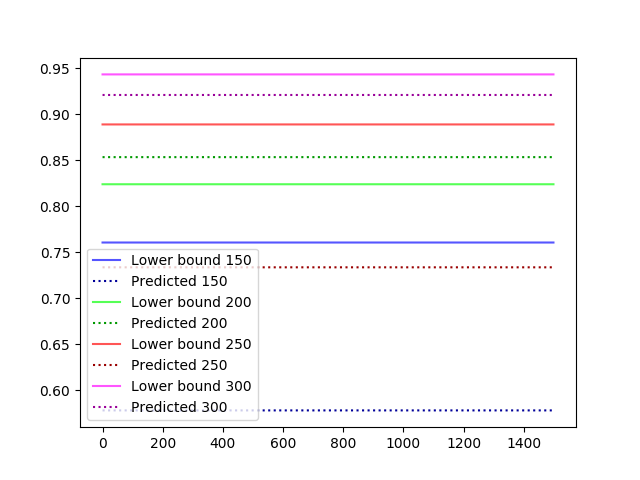

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


size: 150 intial_variance: 3.0000 lower bound: 0.76045 estimate: 0.57796 diff: 0.18249
size: 200 intial_variance: 3.0000 lower bound: 0.82379 estimate: 0.85326 diff: -0.02948
size: 250 intial_variance: 3.0000 lower bound: 0.88881 estimate: 0.73349 diff: 0.15532
size: 300 intial_variance: 3.0000 lower bound: 0.94319 estimate: 0.92083 diff: 0.02237


In [81]:

# h_50 = np.load("data_50.0_h.npy")
# h_100 = np.load("data_100.0_h.npy")
# h_200 = np.load("data_200.0_h.npy")
# h_300 = np.load("data_300.0_h.npy")
# start_runs = 5
# end_runs = 6
# dt = .1
# sigma = 4

# h50_test = []
# h100_test = []
# h200_test = []
# h300_test = []
# count = 0
# for idx in range(h_50.shape[0]):
#     if max(np.nanmean(h_50[idx][250:], axis=0)) < 2.5:
# #         h50_test.append(np.nanmean(h_50[idx], axis=1))
#         h50_test.append(h_50[idx][:,0])
# for idx in range(h_100.shape[0]):
#     if max(np.nanmean(h_100[idx][250:], axis=0)) < 2.5:
# #         h100_test.append(np.nanmean(h_100[idx], axis=1))
#         h100_test.append(h_100[idx][:,0])
# for idx in range(h_200.shape[0]):
#     if max(np.nanmean(h_200[idx][250:], axis=0)) < 3.5:
# #         h200_test.append(np.nanmean(h_200[idx], axis=1))
#         h200_test.append(h_200[idx][:,0])
# for idx in range(h_300.shape[0]):
#     if max(np.nanmean(h_300[idx][250:], axis=0)) < 3.5:
#         h300_test.append(h_300[idx][:,0])
# #         h300_test.append(np.nanmean(h_300[idx], axis=1))

plt.figure()
data = [h150_test, h200_test, h250_test, h300_test, h350_test]
dists = [150, 200, 250, 300, 350]
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF']
predicted_colors = ['#000099', '#009900', '#990000', '#990099']
for idx in range(4):
    plot_data = np.mean(data[idx], axis=0)[:1500]
    lower_bound = np.mean(plot_data[500:])
#     plt.plot(plot_data, label='Sim {}'.format(dists[idx]), color=colors[idx])
    map_size = 7*dists[idx]
    
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(3, int(map_size), dt, sigma,
                                                                     len(probability_array[idx]),
                                                                     probability_array[idx], 10)


#     test = fill_prediction(np.copy(predicted_ent))

    nodes, edges = createGridLayout(2,3,dists[idx], dists[idx])
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
#     print(dur, test.shape)
    
    predicted_lower_bound = np.nanmean(predicted_ent)#[:int(dur/dt)])
    plt.plot([lower_bound for jdx in range(plot_data.shape[0])], color=lower_bound_colors[idx],
                                          label='Lower bound {}'.format(dists[idx]))

    plt.plot([predicted_lower_bound for jdx in range(plot_data.shape[0])], ':',
             color=predicted_colors[idx], label='Predicted {}'.format(dists[idx]))
    print('size: {} intial_variance: {:.4f} lower bound: {:.5f} estimate: {:.5f} diff: {:.5f}'.format(dists[idx], 
                                                                             3,#initial_avg_variances[idx],
                                                                             lower_bound, predicted_lower_bound,
                                                                             lower_bound - predicted_lower_bound))
plt.legend()

<IPython.core.display.Javascript object>


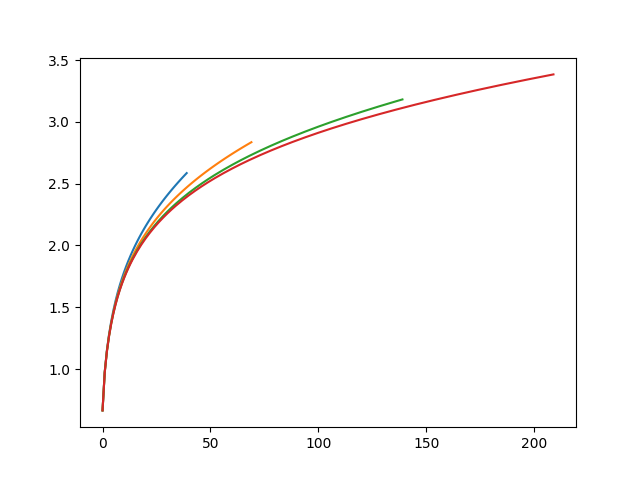

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


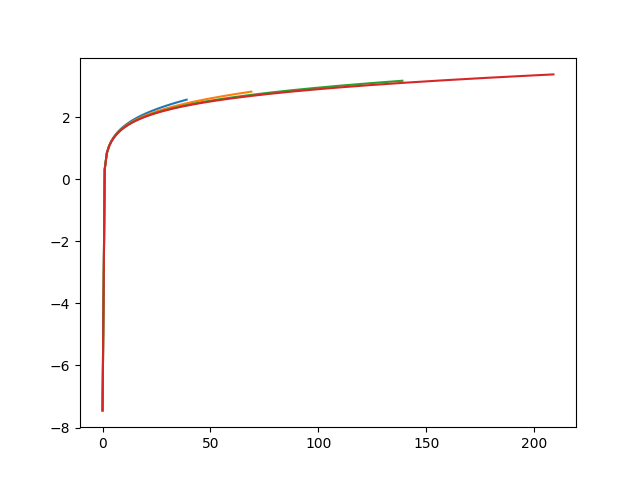

In [253]:
plt.figure()
predicted_ent_data = []
for idx in range(4):
    map_size = 7*dists[idx]
    
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.25, int(map_size), dt, sigma,
                                                                     len(probability_array[idx]),
                                                                     probability_array[idx])
    predicted_ent_data.append(predicted_ent)
    plt.plot(predicted_ent)
plt.figure()
for idx in range(4):
    map_size = 7*dists[idx]
    
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.007, int(map_size), dt, sigma,
                                                                     len(probability_array[idx]),
                                                                     probability_array[idx])
    predicted_ent_data.append(predicted_ent)
    plt.plot(predicted_ent)


duration:  40.0
calculate mode probabilities


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


<IPython.core.display.Javascript object>


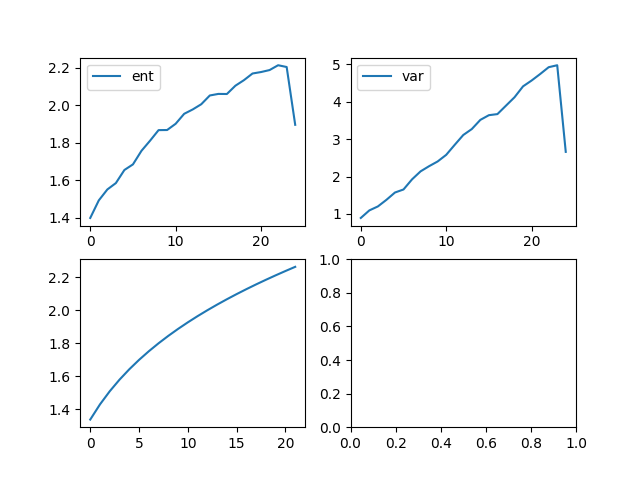

In [291]:
dist_e = 50
base = {
    0: {'offset': dist_e/v0,
       'options': [1,1]},
    1: {'offset': dist_e*3/v0,
       'options': [0,1]}
}
nodes, edges = createGridLayout(2,3,dist_e, dist_e)
r = Roadmap(nodes, edges, rotate=False)
avg_dist = getAvgDistance(r)
dur = 2*avg_dist/Va
print('duration: ', ceil(dur)/dt)

t = np.array([dt*idx for idx in range(22)])#int(ceil(dur)/dt))])
print('calculate mode probabilities')
probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 10)
probabilites_by_time = []
for jdx in range(len(probabilities[1])):
    probabilites_by_time.append({})
    for key in probabilities.keys():
        probabilites_by_time[-1][key] = probabilities[key][jdx]
map_size = 50*7
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.85, int(map_size), dt, sigma,
                                                                 len(probabilites_by_time),
                                                                 probabilites_by_time)
fig, ax = plt.subplots(2,2)
test = np.load("data_50.0_h.npy")
test_v = np.load("data_50.0_v.npy")
start_idx = 290
end_idx = start_idx + 25
ax[0,0].plot(test[400][:,0][start_idx:end_idx], label='ent')
ax[0,0].legend()
ax[0,1].plot(test_v[400][:,0][start_idx:end_idx], label='var')
ax[0,1].legend()
ax[1,0].plot(predicted_ent)

<IPython.core.display.Javascript object>


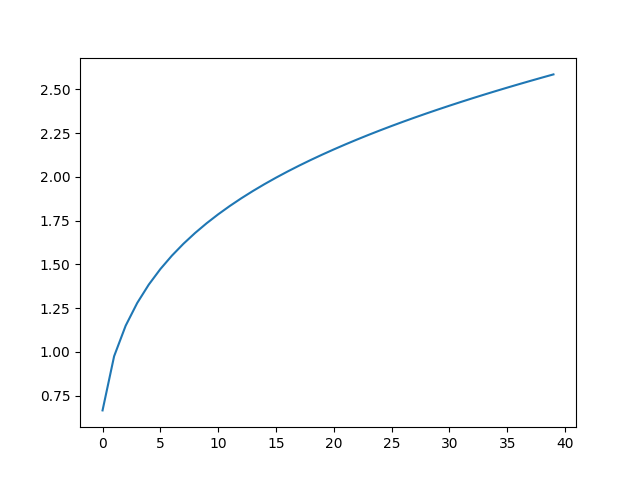

In [266]:
plt.figure()
plt.plot(predicted_ent_data[0])
# for test in predicted_ent_data:
# #     print(test)
#     print(np.sum(test)/len(test))

In [19]:
probabilities = np.load("3x3-mode-prob.npy")[0]
probability_3x3 = []
probabilites_by_time = []
for jdx in range(len(probabilities[1])):
    probabilites_by_time.append({})
    for key in probabilities.keys():
        probabilites_by_time[-1][1/key] = key*probabilities[key][jdx]
probability_3x3.append(probabilites_by_time)
# # print(probability_3x3[0])
# dist_e = 50
# nodes, edges = createGridLayout(3,3,dist_e, dist_e)
# r = Roadmap(nodes, edges, rotate=False)
# avg_dist = getAvgDistance(r)
# dur = 2*avg_dist/Va
# print(dur)
# plt.figure()
# for key in probabilities.keys():
#     plot_data = key*probabilities[key][:ceil(dur/dt)]
#     if np.max(plot_data) > 0:
#         plt.plot(plot_data)

<IPython.core.display.Javascript object>


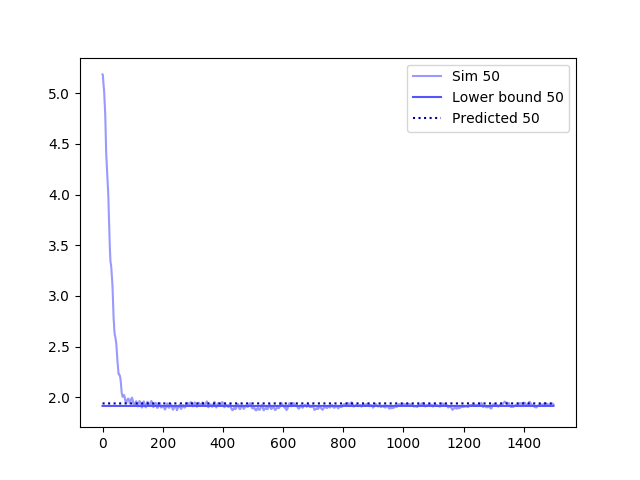

size: 50 lower bound: 1.914184446432714 estimate: 1.9391011690570004


/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


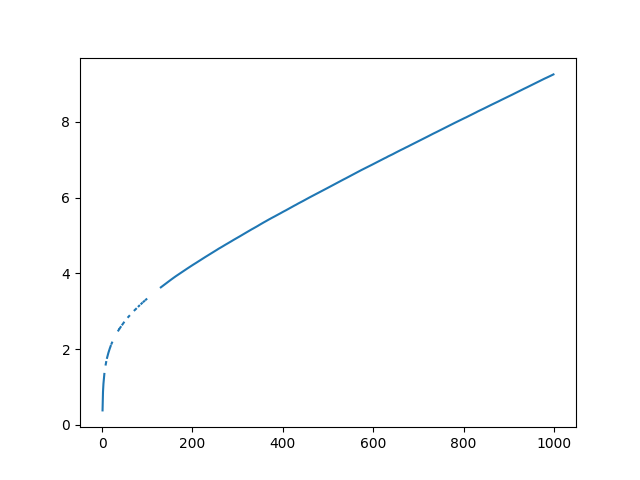

In [38]:

h_50 = np.load("data_3x3-50_h.npy")
start_runs = 5
end_runs = 6
dt = .1
sigma = 4
h50_test = []
h100_test = []
h200_test = []
h300_test = []
count = 0
for idx in range(h_50.shape[0]):
    if max(np.nanmean(h_50[idx][250:], axis=0)) < 2.5:
        h50_test.append(np.nanmean(h_50[idx], axis=1))
# for idx in range(h_100.shape[0]):
#     if max(np.nanmean(h_100[idx][250:], axis=0)) < 2.5:
#         h100_test.append(np.nanmean(h_100[idx], axis=1))
# for idx in range(h_200.shape[0]):
#     if max(np.nanmean(h_200[idx][250:], axis=0)) < 3.5:
#         h200_test.append(np.nanmean(h_200[idx], axis=1))
# for idx in range(h_300.shape[0]):
#     if max(np.nanmean(h_300[idx][250:], axis=0)) < 3.5:
#         h300_test.append(np.nanmean(h_300[idx], axis=1))
# print(h300_test)
plt.figure()
data = [h50_test, h100_test, h200_test, h300_test]
dists = [50, 100, 200, 300]
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF']
predicted_colors = ['#000099', '#009900', '#990000', '#990099']
for idx in range(1):
    plot_data = np.mean(data[idx], axis=0)[:1500]
    lower_bound = np.mean(plot_data[500:])
    plt.plot(plot_data, label='Sim {}'.format(dists[idx]), color=colors[idx])
    map_size = 7*dists[idx]
    
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.0168, int(map_size), dt, sigma,
                                                                     len(probability_3x3[idx]),
                                                                     probability_3x3[idx])
#     for jdx in len(predicted_ent):
#         print()
#     print(predicted_ent)

#     test = fill_prediction(np.copy(predicted_ent))

    nodes, edges = createGridLayout(3,3,dists[idx], dists[idx])
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
    predicted_lower_bound = np.nanmean(predicted_ent[:int(dur/dt)])
    plt.plot([lower_bound for jdx in range(plot_data.shape[0])], color=lower_bound_colors[idx],
                                          label='Lower bound {}'.format(dists[idx]))

    plt.plot([predicted_lower_bound for jdx in range(plot_data.shape[0])], ':',
             color=predicted_colors[idx], label='Predicted {}'.format(dists[idx]))
    print('size: {} lower bound: {} estimate: {}'.format(dists[idx], lower_bound, predicted_lower_bound))

plt.legend()
plt.figure()
plt.plot(predicted_ent)

In [68]:

h_150 = np.load("data_2x3-150_h.npy")
h_200 = np.load("data_2x3-200_h.npy")
h_250 = np.load("data_2x3-250_h.npy")
h_300 = np.load("data_2x3-300_h.npy")
h_350 = np.load("data_2x3-350_h.npy")
start_runs = 5
end_runs = 6
dt = .1
sigma = 4

h150_test = []
h200_test = []
h250_test = []
h300_test = []
h350_test = []
h150_test = h_150
h200_test = h_200
h250_test = h_250
h300_test = h_300
h350_test = h_350
# count = 0
# for idx in range(h_50.shape[0]):
#     if max(np.nanmean(h_50[idx][250:], axis=0)) < 2.5:
#         h50_test.append(np.nanmean(h_50[idx], axis=1))
#     else:
# #         print('50', idx)
#         count += 1
# for idx in range(h_100.shape[0]):
#     if max(np.nanmean(h_100[idx][250:], axis=0)) < 2.5:
#         h100_test.append(np.nanmean(h_100[idx], axis=1))
# #     else:
# #         print('100', idx)
# for idx in range(h_200.shape[0]):
#     if max(np.nanmean(h_200[idx][250:], axis=0)) < 3.5:
#         h200_test.append(np.nanmean(h_200[idx], axis=1))
# #     else:
# #         print('200', idx)
# for idx in range(h_300.shape[0]):
#     if max(np.nanmean(h_300[idx][250:], axis=0)) < 3.5:
#         h300_test.append(np.nanmean(h_300[idx], axis=1))
# #     else:
# #         print('300', idx)
# print(count)

In [30]:
# plt.figure()
# plt.plot(h_100[10])
# print(np.min(h_50[6]))

<IPython.core.display.Javascript object>


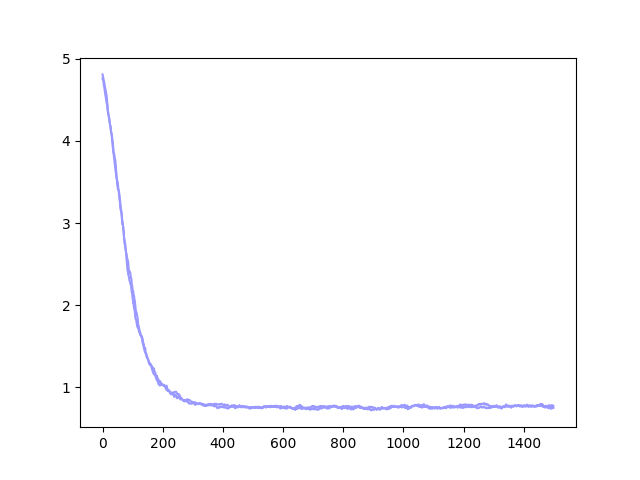

KeyError: 0

In [72]:

# h_50 = np.load("data_3x3-50_h.npy")
# start_runs = 5
# end_runs = 6
# dt = .1
# sigma = 4
# h50_test = []
# h100_test = []
# h200_test = []
# h300_test = []
# count = 0
# for idx in range(h_50.shape[0]):
#     if max(np.nanmean(h_50[idx][250:], axis=0)) < 2.5:
#         h50_test.append(np.nanmean(h_50[idx], axis=1))
# # for idx in range(h_100.shape[0]):
# #     if max(np.nanmean(h_100[idx][250:], axis=0)) < 2.5:
# #         h100_test.append(np.nanmean(h_100[idx], axis=1))
# # for idx in range(h_200.shape[0]):
# #     if max(np.nanmean(h_200[idx][250:], axis=0)) < 3.5:
# #         h200_test.append(np.nanmean(h_200[idx], axis=1))
# # for idx in range(h_300.shape[0]):
# #     if max(np.nanmean(h_300[idx][250:], axis=0)) < 3.5:
# #         h300_test.append(np.nanmean(h_300[idx], axis=1))
# # print(h300_test)
plt.figure()
data = [h150_test, h200_test, h250_test, h300_test, h350_test]
dists = [150, 200, 250, 300, 350]
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF']
predicted_colors = ['#000099', '#009900', '#990000', '#990099']
for idx in range(len(dists)):
    plot_data = np.mean(data[idx], axis=0)[:1500]
    lower_bound = np.mean(plot_data[500:])
    plt.plot(plot_data, label='Sim {}'.format(dists[idx]), color=colors[idx])
    map_size = 7*dists[idx]
    probability = probability_array[idx]
    
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(.007, int(map_size), dt, sigma,
                                                                     len(probability[idx]),
                                                                     probability[idx], 10)
#     for jdx in len(predicted_ent):
#         print()
#     print(predicted_ent)

#     test = fill_prediction(np.copy(predicted_ent))

    nodes, edges = createGridLayout(3,3,dists[idx], dists[idx])
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
    predicted_lower_bound = np.nanmean(predicted_ent[:int(dur/dt)])
    plt.plot([lower_bound for jdx in range(plot_data.shape[0])], color=lower_bound_colors[idx],
                                          label='Lower bound {}'.format(dists[idx]))

    plt.plot([predicted_lower_bound for jdx in range(plot_data.shape[0])], ':',
             color=predicted_colors[idx], label='Predicted {}'.format(dists[idx]))
    print('size: {} lower bound: {} estimate: {}'.format(dists[idx], lower_bound, predicted_lower_bound))

# plt.legend()
# plt.figure()
# plt.plot(predicted_ent)

In [29]:
# mu = int(350/2)
# x = np.array([idx for idx in range(350)])
# # print(x)
# variance = .0168
# probs = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
# probs = probs/np.linalg.norm(probs)
# print(probs)

<IPython.core.display.Javascript object>


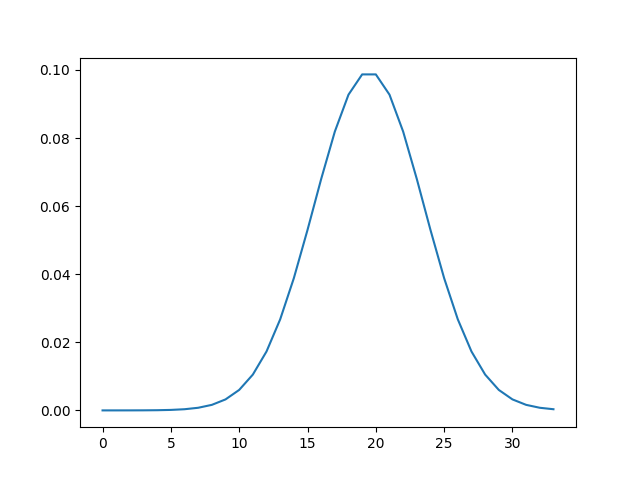

150.0


0.9997670842693926

In [130]:
from scipy.stats import norm
plt.figure()
loc = 50
dist = 350
dt = 10
variance = 40
print((dist-loc)/2.)
x=[idx*dt-(dist-loc)/2. for idx in range(int(dist/dt))]
# print(x)
# plt.plot(x,norm.pdf(x=x,loc=loc, scale=variance))
cdf = norm.cdf(x=x,loc=loc, scale=variance)
# plt.plot(x,cdf)
ppf = []
for idx in range(len(x)-1):
    ppf.append(cdf[idx+1] - cdf[idx])
plt.plot(ppf)
sum(ppf)

In [305]:
dt = .1
dists =      [50, 75, 100, 125, 400]#175, 200, 225, 250, 400]
# dists = [100, 200, 250, 300, 350, 400]
dists = [100, 150, 200, 250, 300, 350]
thresholds = [3,  3.5,4,   4,   5,   5,   5,   5,   5]
probability_array = []
v0 = 10
Va = 40
for idx in range(len(dists)):
    print(dists[idx])
    base = {
        0: {'offset': dists[idx]/v0,
           'options': [1,1]},
        1: {'offset': dists[idx]*3/v0,
           'options': [0,1]}
    }
    nodes, edges = createGridLayout(2,3,dists[idx], dists[idx])
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
    print('duration: ', ceil(dur)/dt)
    
    t = np.array([dt*idx for idx in range(int(ceil(dur)/dt))])
    print('calculate mode probabilities')
    probabilities = getModeProbabilities([1./7, 6./7], [base[0]['offset'], base[1]['offset']], base, t, 10)
    probabilites_by_time = []
    for jdx in range(len(probabilities[1])):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
    probability_array.append(probabilites_by_time)
    print('finished calculation')
# print(probability_array[0])

100
duration:  70.0
calculate mode probabilities


TypeError: getModeProbabilities() takes 3 positional arguments but 5 were given

In [304]:
def get_avg_min_variance(v, h):
    v = np.array(v)
    mins = []
    for jdx in range(h.shape[0]):
        test = h[jdx,:,0]
#         print(test.shape)
#         print(h[jdx].shape, v[jdx].shape)
        for idx in range(test.shape[0]-1):
            
            if test[idx] > test[idx+1]+1:
#                 print(v[jdx].shape)
                mins.append(v[jdx,idx+1,0])
    return np.mean(mins), mins
num_iterations = 5

# raw_data_h = [
#     np.load("data_2x3-{}_h.npy".format(dists[idx])) for idx in range(len(dists))#[:num_iterations,:,:]
# ]
# raw_data_v = [
#     np.load("data_2x3-{}_v.npy".format(dists[idx])) for idx in range(len(dists))#[:num_iterations,:,:]
# ]
# print(raw_data_h)
# raw_data_v = [v_25, v_50, v_75, v_100, v_150, v_175]
start_runs = 5
end_runs = 6
dt = .1
sigma = 4
# data = []
# v_data = []
# data = raw_data_h
# v_data = raw_data_v
# for idx in range(1, len(raw_data_h)):
# #     print(idx)
#     data.append(np.array(
#         [raw_data_h[idx][jdx] for jdx in range(raw_data_h[idx].shape[0]) ]))
# #          if not np.max(np.mean(raw_data_h[idx][jdx], axis=1)[100:]) > thresholds[idx]]))
#     v_data.append(np.array(
#         [raw_data_v[idx][jdx] for jdx in range(raw_data_h[idx].shape[0]) ]))
# #          if not np.max(np.mean(raw_data_h[idx][jdx], axis=1)[100:]) > thresholds[idx]]))
# #     print(data[-1].shape, v_data[-1].shape)
# #     if idx == 4:
# #         print(len(data))
# #         print(np.mean(data[3], axis=0))
# #         print(data[3])
count = 0
# print(data[0].shape, v_data[0].shape)
# print(data)

# plt.figure()
# data = [h50, h75, h100]#, h200, h300, h400]
# v_data = [v50, v75, v100]#, v_100, v_200, v_300, v_400]

# data = [h25, h50, h75, h100, h200, h300, h400]
# v_data = [v_25, v_50, v_75, v_100, v_200, v_300, v_400]
# dists = [25, 50, 75, 100, 200, 300, 400]
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF', '#FFFF99', '#99FFFF', '#99999F', '#9999F9', '#999F99']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF', '#FFFF55', '#55FFFF', '#55555F', '#5555F5', '#555F55']
predicted_colors = ['#000099', '#009900', '#990000', '#990099', '#999900', '#009999', '#000009', '#000090', '#000900']
initial_avg_variances = []
initial_variances = []
step_sizes = [1,5,10,10]
for idx in range(0,len(dists)):
#     print(idx)
    data = np.load("data_2x3-{}_h.npy".format(dists[idx]))
    v_data = np.load("data_2x3-{}_v.npy".format(dists[idx]))
    plot_data = np.mean(data, axis=0)

#     print(plot_data)
    print(v_data.shape, data.shape)
    num_iterations = 500
    variance_data = v_data[:num_iterations,:,:]
    entropy_data = data[:num_iterations,:,:]
    avg_min_variance, variance_mins = get_avg_min_variance(variance_data, entropy_data)
    initial_avg_variances.append(avg_min_variance)
    initial_variances.append(variance_mins)
#     avg_min_variance = 3.6
    print(dists[idx], 'variance: ', avg_min_variance)
#     lower_bound = np.mean(plot_data[750:])
#     plt.plot(np.mean(plot_data, axis=1), label='Sim {}'.format(dists[idx]), color=colors[idx])
#     map_size = 7*dists[idx]
    
#     predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt, sigma,
#                                                                      len(probability_array[idx]),
#                                                                      probability_array[idx], step_sizes[idx])


#     test = fill_prediction(np.copy(predicted_ent))

#     nodes, edges = createGridLayout(2,3,dists[idx], dists[idx])
#     r = Roadmap(nodes, edges, rotate=False)
#     avg_dist = getAvgDistance(r)
#     dur = 2*avg_dist/Va
# #     print(dur, test.shape)
    
#     predicted_lower_bound = np.nanmean(predicted_ent)#[:int(dur/dt)])
#     plt.plot([lower_bound for jdx in range(plot_data.shape[0])], color=lower_bound_colors[idx],
#                                           label='Lower bound {}'.format(dists[idx]))

#     plt.plot([predicted_lower_bound for jdx in range(plot_data.shape[0])], ':',
#              color=predicted_colors[idx], label='Predicted {}'.format(dists[idx]))
#     print('size: {} variance: {:.4f} lower bound: {:.4f} estimate: {:.4f}'.format(dists[idx], avg_min_variance, lower_bound, predicted_lower_bound))
# plt.legend()

# information filter - 
# skew is 3rd moment
# curtosis is 4th moment

NameError: name 'dists' is not defined

100
(2486, 2000, 2) (2486, 2000, 2)
150
(2719, 2000, 2) (2719, 2000, 2)
200
(2708, 2000, 2) (2708, 2000, 2)
250
(3173, 2000, 2) (3173, 2000, 2)
300
(2778, 2000, 2) (2778, 2000, 2)
350
(2368, 2000, 2) (2368, 2000, 2)


<IPython.core.display.Javascript object>


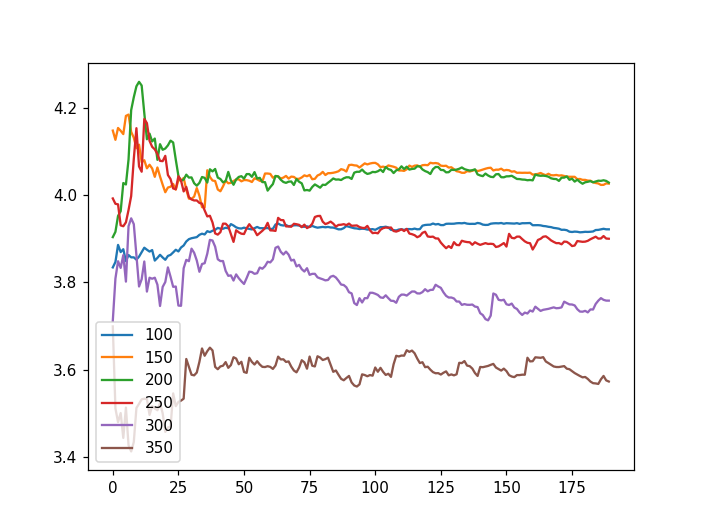

In [306]:
means = []
for idx in range(0,len(dists)):
#     print(idx)
    print(dists[idx])
    means.append([])
#     print(idx)
#     data = np.load("data_2x3-{}-10_h.npy".format(dists[idx]))
#     v_data = np.load("data_2x3-{}-10_v.npy".format(dists[idx]))
    data = np.load("data_2x3-{}-10_h.npy".format(dists[idx]))
    v_data = np.load("data_2x3-{}-10_v.npy".format(dists[idx]))
    print(data.shape, v_data.shape)
    plot_data = np.mean(data, axis=0)

#     print(plot_data)
#     print(v_data.shape, data.shape)
#     num_iterations = 500
    for num_iterations in range(100, 2000, 10):
#         print(num_iterations)
        variance_data = v_data[:num_iterations,:,:]
        entropy_data = data[:num_iterations,:,:]
        avg_min_variance, variance_mins = get_avg_min_variance(variance_data, entropy_data)
        means[-1].append(avg_min_variance)
#         print(means)
#     initial_avg_variances.append(avg_min_variance)
#     initial_variances.append(variance_mins)
#     avg_min_variance = 3.6
#     print(dists[idx], 'variance: ', avg_min_variance)
plt.figure()
plt.title("Initial Variance Average over number of iterations")
for idx in range(len(dists)):
    plt.plot(means[idx], label=dists[idx])
plt.legend()

<IPython.core.display.Javascript object>


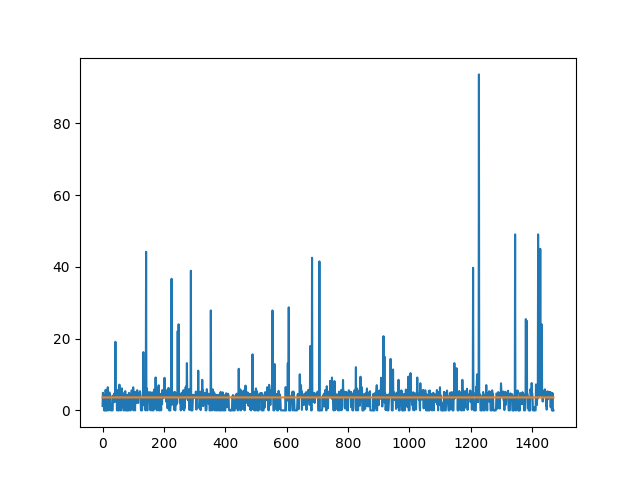

In [52]:
plt.figure()
tmp = np.array(initial_variances[4])
# # tmp = tmp[tmp<10]
# # tmp = tmp[tmp>0]
plt.plot(tmp)
plt.plot([np.mean(tmp) for idx in range(tmp.shape[0])])
# print(np.mean(tmp))
# print(initial_variances[0])
# for idx in range(len(initial_avg_variances)):
#     print(initial_avg_variances[idx])

4.048881995102513
4.032856360238168
3.935338550676214
3.840107555938488
3.617934917524874


<IPython.core.display.Javascript object>


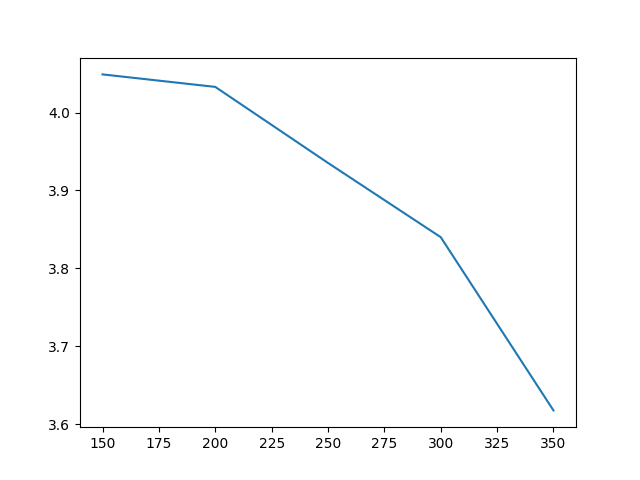

In [49]:

for idx in range(len(initial_variances)):
#     print(len(initial_variances[idx]))
    print(np.mean(initial_variances[idx]))
plt.figure()
plt.plot(dists[:len(initial_avg_variances)], initial_avg_variances)

In [515]:
durs = [50,100,200,300]
var_initial = [3.27, 3.81, 4.07, 4.347]
print(len(var_initial))
for idx in range(len(var_initial)-1):
#     print(idx)
    print(var_initial[idx+1] - var_initial[idx])
    print((durs[idx+1] - durs[idx])*(dt*sigma)**2)
#     print((dt*sigma)**2)

4
0.54
8.000000000000002
0.26000000000000023
16.000000000000004
0.27700000000000014
16.000000000000004


## 3x3 Mode Splitting